# 1. Импорт необходимых библиотек и модулей

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# print("TensorFlow version:", tf.__version__)

%matplotlib inline

# 2. Чтение данных из файла
## 2.1 Чтение экспериментальных данных из .csv

In [2]:
# DATASET_PATH = '../dataset'
# FILE_NAME = 'КТ117№1_п1(база 2)_2500Гц-1Гц_1пФ_+10С_-1В-2В_100мВ_20мкс_шаг_0,1.csv'

In [3]:
# file_name = DATASET_PATH + '/' + FILE_NAME
file_name = 'test.csv'

# TIME_CONSTANT = 0.005

# AMPL = 3.0

# F_PULSE = 20 * 10 ** (-6)

# STDDEV = 0.2

In [4]:
data = pd.read_csv(file_name, 
                   header = 0,
                   parse_dates = [0],
                   infer_datetime_format = True
                  )
data.head()

,frequency_hz,dlts_pf,f_pulse
0,1.0,0.024528,0.00002
1,1.0078626272670832,-0.200976,0.00002
2,1.0157870754417073,0.004056,0.00002
3,1.023773830598626,0.252659,0.00002
4,1.031823382634417,0.307020,0.00002


## 2.2 Подготовка данных для TensorFlow

In [5]:
dlts = tf.Variable(data.dlts_pf.to_numpy(), 
                   dtype = 'float64')

frequency = tf.Variable(data.frequency_hz.to_numpy(),
                        dtype = 'float64')

# filling_pulse = tf.Variable(data.f_pulse.mean() * 10**-6, dtype = 'float64')
filling_pulse = tf.Variable(data.f_pulse.mean(), dtype = 'float64')

In [6]:
dlts

<tf.Variable 'Variable:0' shape=(1000,) dtype=float64, numpy=
array([ 2.45275890e-02, -2.00976060e-01,  4.05599600e-03,  2.52659500e-01,
        3.07020220e-01, -5.14327030e-02,  2.46459770e-02, -2.40072130e-01,
       -7.53323300e-02, -5.18701200e-02,  3.77550800e-01, -1.66544540e-01,
        5.56551100e-02,  1.15160555e-01, -7.59197500e-02, -5.22670560e-02,
        4.69633940e-02, -2.39582860e-02,  3.84329700e-02, -2.57194340e-01,
        4.14041000e-01,  2.77083780e-01,  1.66879640e-01,  1.81175300e-01,
        1.35791900e-01, -1.35475840e-01, -1.74026010e-01,  6.14911900e-02,
        8.11985800e-03, -1.09279690e-01, -7.84364040e-02,  3.87317870e-01,
        5.77338820e-02,  1.50382250e-01, -2.41441490e-01, -1.16849390e-01,
       -3.40994150e-01, -3.87656240e-01, -8.36880300e-02,  6.47353500e-02,
        1.14760794e-01, -6.03957400e-02,  2.01895760e-01,  8.65341050e-02,
        1.11634160e-01,  1.77883500e-01, -1.22464970e-01, -2.63573490e-02,
       -2.60571820e-02,  3.00074760e-0

In [7]:
frequency

<tf.Variable 'Variable:0' shape=(1000,) dtype=float64, numpy=
array([1.00000000e+00, 1.00786263e+00, 1.01578708e+00, 1.02377383e+00,
       1.03182338e+00, 1.03993623e+00, 1.04811286e+00, 1.05635378e+00,
       1.06465949e+00, 1.07303051e+00, 1.08146735e+00, 1.08997053e+00,
       1.09854056e+00, 1.10717797e+00, 1.11588330e+00, 1.12465708e+00,
       1.13349984e+00, 1.14241212e+00, 1.15139448e+00, 1.16044747e+00,
       1.16957163e+00, 1.17876754e+00, 1.18803575e+00, 1.19737683e+00,
       1.20679136e+00, 1.21627991e+00, 1.22584307e+00, 1.23548141e+00,
       1.24519554e+00, 1.25498605e+00, 1.26485354e+00, 1.27479861e+00,
       1.28482188e+00, 1.29492395e+00, 1.30510546e+00, 1.31536702e+00,
       1.32570926e+00, 1.33613281e+00, 1.34663833e+00, 1.35722644e+00,
       1.36789781e+00, 1.37865308e+00, 1.38949292e+00, 1.40041798e+00,
       1.41142894e+00, 1.42252648e+00, 1.43371128e+00, 1.44498402e+00,
       1.45634539e+00, 1.46779609e+00, 1.47933682e+00, 1.49096830e+00,
       1.502691

In [8]:
filling_pulse

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.999999999999952e-05>

## 2.3 График

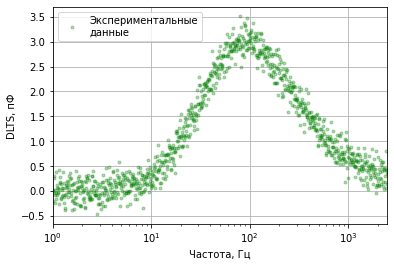

In [9]:
plt.semilogx(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha = 0.3)
plt.grid()
plt.xlim([1, 2500])
# plt.ylim([-0.006, 0])
plt.legend()
plt.ylabel('DLTS, пФ')
plt.xlabel('Частота, Гц')
plt.show()

## 2.4 Подготовка данных

In [10]:
frequency = np.log10(frequency)
frequency

array([0.        , 0.00340134, 0.00680268, 0.01020402, 0.01360537,
       0.01700671, 0.02040805, 0.02380939, 0.02721073, 0.03061207,
       0.03401341, 0.03741475, 0.0408161 , 0.04421744, 0.04761878,
       0.05102012, 0.05442146, 0.0578228 , 0.06122414, 0.06462549,
       0.06802683, 0.07142817, 0.07482951, 0.07823085, 0.08163219,
       0.08503353, 0.08843488, 0.09183622, 0.09523756, 0.0986389 ,
       0.10204024, 0.10544158, 0.10884292, 0.11224426, 0.11564561,
       0.11904695, 0.12244829, 0.12584963, 0.12925097, 0.13265231,
       0.13605365, 0.139455  , 0.14285634, 0.14625768, 0.14965902,
       0.15306036, 0.1564617 , 0.15986304, 0.16326438, 0.16666573,
       0.17006707, 0.17346841, 0.17686975, 0.18027109, 0.18367243,
       0.18707377, 0.19047512, 0.19387646, 0.1972778 , 0.20067914,
       0.20408048, 0.20748182, 0.21088316, 0.21428451, 0.21768585,
       0.22108719, 0.22448853, 0.22788987, 0.23129121, 0.23469255,
       0.23809389, 0.24149524, 0.24489658, 0.24829792, 0.25169

In [11]:
scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor
dlts

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([ 2.09582928e-02, -1.71729684e-01,  3.46576061e-03,  2.15892063e-01,
        2.62342119e-01, -4.39481292e-02,  2.10594528e-02, -2.05136428e-01,
       -6.43698421e-02, -4.43218925e-02,  3.22608970e-01, -1.42308697e-01,
        4.75560844e-02,  9.84021965e-02, -6.48717797e-02, -4.46610657e-02,
        4.01292016e-02, -2.04718357e-02,  3.28401393e-02, -2.19766985e-01,
        3.53789054e-01,  2.36762080e-01,  1.42595033e-01,  1.54810364e-01,
        1.16031233e-01, -1.15761167e-01, -1.48701451e-01,  5.25428882e-02,
        6.93824255e-03, -9.33771249e-02, -6.70222060e-02,  3.30954719e-01,
        4.93323500e-02,  1.28498371e-01, -2.06306516e-01, -9.98452694e-02,
       -2.91372105e-01, -3.31243849e-01, -7.15096065e-02,  5.53149525e-02,
        9.80606094e-02, -5.16068499e-02,  1.72515548e-01,  7.39415159e-02,
        9.53889684e-02,  1.51997593e-01, -1.04643661e-01, -2.25217830e-02,
       -2.22652969e-02,  2.56407374e-01,  3.1836275

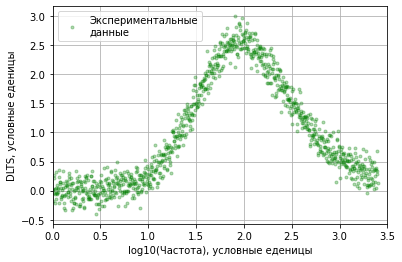

In [12]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

# 3. Описание модели
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ -- масштабный множитель.

Таким образом,
$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

# 4. Кодирование модели
## 4.1 Функция `get_phi()`
$$ \tau = 10^{time\_constant\_power} $$
$$ F_0 = 10^{frequency\_power}$$
$$ a = \tau F_0 $$
$$ b = t_1 F_0 $$
$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$
$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$
$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$
$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$
$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

In [13]:
def get_phi(frequency_power, time_constant_power, M, filling_pulse):
    time_constant = tf.pow(10.0, time_constant_power)
    frequency = tf.pow(10, frequency_power)

    a = time_constant * frequency
    b = filling_pulse * frequency

    exp0 = tf.exp(-0.05 / (a))
    exp1 = tf.exp((b - 0.45) / (a))
    exp2 = tf.exp(-0.5 / (a))
    exp3 = tf.exp((b - 0.95) / (a))

    phi = M * a * exp0 * (1.0 - exp1 - exp2 + exp3)

    return phi

## 4.2 Функция `get_dlts()`
$$ DLTS = A \cdot \phi $$

In [14]:
# def get_dlts(amplitude, M, frequency_power, time_constant_power, filling_pulse):
#     dlts = amplitude * get_phi(frequency_power, 
#                                time_constant_power, 
#                                M, 
#                                filling_pulse)
    
#     return dlts

## 4.3 Определение функции потерь для DLTS (для модели). Функция `loss_dlts()`
Среднеквадратическая ошибка


In [15]:
# def loss(target_y, predicted_y):
#     return tf.reduce_mean(tf.square(target_y - predicted_y))

## 4.5 Определение модели для $\phi$

In [16]:
class PhiModel(tf.Module):
    def __init__(self, 
                 time_constant_power,
                 filling_pulse,
                 M = 5.861,
                 **kwargs):
        
        super().__init__(**kwargs)
        
        self.time_constant_power = tf.Variable(time_constant_power, 
                                               dtype='float64', 
                                               name='time constant power'
                                              )
        self.filling_pulse = tf.Variable(filling_pulse, 
                                         dtype='float64',
                                         name='filling pulse'
                                        )
        self.M = tf.Variable(M, 
                             dtype='float64',
                             name='M'
                            )
        
    def __call__(self, frequency_power):
        return get_phi(frequency_power, 
                       self.time_constant_power, 
                       self.M, 
                       self.filling_pulse)
    
    
phi_model = PhiModel(time_constant_power=tf.Variable(-3.0, dtype='float64'), 
                     filling_pulse=filling_pulse)

for i, v in enumerate(phi_model.variables):
    print(f'Variable {i}:', v)

print(phi_model(frequency_power=tf.Variable(3.0, dtype='float64')))

Variable 0: <tf.Variable 'M:0' shape=() dtype=float64, numpy=5.861>
Variable 1: <tf.Variable 'filling pulse:0' shape=() dtype=float64, numpy=1.999999999999952e-05>
Variable 2: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-3.0>
tf.Tensor(0.7666617093509145, shape=(), dtype=float64)


## 4.6 Идентификация коэффициента $M$

In [17]:
def train_M(phi_model,
            learning_rate=0.1,
            n_iters=100,
            stop_val = None,
            verbose = False
           ):
    
    prev_loss = tf.Variable(np.inf, dtype='float64')
    max_freq_pow = tf.Variable(-phi_model.time_constant_power, dtype='float64')
    
    for _ in range(n_iters):
        with tf.GradientTape() as tape:
            current_loss = 0.0 - phi_model(max_freq_pow)
            
        if verbose:
            print(_)
            print(current_loss)
            print(max_freq_pow)
        
        if stop_val is not None:
            if tf.abs(current_loss - prev_loss) < stop_val:
                break
        
        dfreq_pow = tape.gradient(current_loss, max_freq_pow)
        max_freq_pow.assign_sub(learning_rate * dfreq_pow)
        
        prev_loss = current_loss
        
    phi_model.M = phi_model.M / phi_model(max_freq_pow)

In [18]:
train_M(phi_model,
        learning_rate=0.2,
        n_iters=100,
        stop_val = 10**-10,
        verbose = True
       )

0
tf.Tensor(-0.7666617093509145, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0>
1
tf.Tensor(-0.9330581559008368, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.802874102155242>
2
tf.Tensor(-0.9859552099662315, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.676580828604517>
3
tf.Tensor(-0.9896401527850606, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.640731963100184>
4
tf.Tensor(-0.98970905667989, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6357570793749963>
5
tf.Tensor(-0.9897099286163724, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635196461552543>
6
tf.Tensor(-0.9897099390884785, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635135011043419>
7
tf.Tensor(-0.9897099392135181, shape=(), dtype=float64)
<tf.Variable 'Variable:0' 

In [19]:
phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.921937092648238>

In [20]:
del phi_model

## 4.7 Определение модели частотного скана

In [21]:
class FeqScanModel(tf.Module):
    
    def __init__(self,
                 amplitude,
                 time_constant_power,
                 filling_pulse,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        
        self.time_constant_power = tf.Variable(time_constant_power, dtype='float64')
    
        self.phi_model = PhiModel(time_constant_power=self.time_constant_power, 
                                  filling_pulse=self.filling_pulse)
        
        train_M(self.phi_model,
                learning_rate=0.2,
                n_iters=100,
                stop_val = 10**-10,
                verbose = False
               )
        

    def __call__(self, frequency_power):
        return self.amplitude * self.phi_model(frequency_power)
    
    
    def fit(self, 
            f_powers, 
            dlts_vals,
            learning_rate = 0.1,
            n_iters = 1000,
            stop_val = None,
            verbose = False
           ):
        frequency_powers = tf.Variable(f_powers, dtype='float64')
        dlts = tf.Variable(dlts_vals, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        for _ in range(n_iters):
            
            train_M(self.phi_model,
                    learning_rate=0.2,
                    n_iters=100,
                    stop_val = 10**-10,
                   )
        
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_powers)
                current_loss = tf.reduce_mean(tf.square(dlts - predicted_dlts))

            dampl, dtime_const_pow = tape.gradient(current_loss, [self.amplitude, 
                                                                  self.phi_model.time_constant_power])

            self.amplitude.assign_sub(learning_rate * dampl)
            self.phi_model.time_constant_power.assign_sub(learning_rate * dtime_const_pow)
            
            self.time_constant_power = self.phi_model.time_constant_power
            
            if verbose:
                print(_)
                print('amp:',self.amplitude)
                print('tau:',self.time_constant_power)
                print('M:', self.phi_model.M)
                print('Loss:', current_loss)
            
            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break
                    
            prev_loss = current_loss

In [22]:
fs_model = FeqScanModel(amplitude = 2.0,
                        time_constant_power = -2.5,
                        filling_pulse = 20.0*10**-6)

In [23]:
new_frequency = tf.Variable(frequency, dtype='float64')

In [24]:
new_dlts = fs_model(new_frequency)

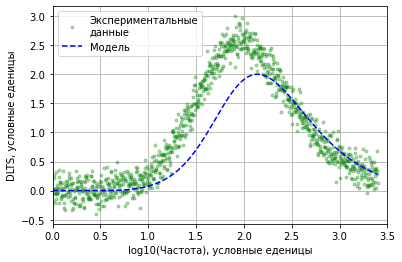

In [25]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [26]:
fs_model.fit(f_powers = tf.Variable(frequency, dtype='float64'), 
             dlts_vals = tf.Variable(dlts, dtype='float64'),
             learning_rate = 0.2,
             n_iters = 1000,
             stop_val = 10**-10,
             verbose = False
            )

In [27]:
fs_model.amplitude / tf.Variable(scale_factor, dtype='float64')

<tf.Tensor: shape=(), dtype=float64, numpy=2.9944298151433792>

In [28]:
tf.pow(10, fs_model.time_constant_power)

<tf.Tensor: shape=(), dtype=float64, numpy=0.005005916337638267>

In [29]:
fs_model.phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.868853562450457>

In [30]:
model = fs_model(new_frequency)

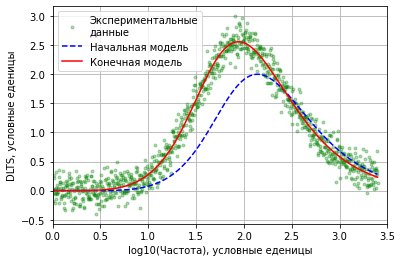

In [31]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные',alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Начальная модель')
plt.plot(new_frequency.numpy(), model.numpy(), 'r', label='Конечная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [32]:
tf.sqrt(tf.reduce_mean(tf.square(tf.Variable(dlts, dtype='float64') - model)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.16590361483993687>